## Production Model: Binary Classification with Random Forest Classifier ##

This notebook contains the production model for a binary classification if an animal will get adopted or not. 

In [25]:
#import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, f1_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
import pickle

In [2]:
#change notebook column view 

pd.set_option('display.max_columns', 200)

In [3]:
#read in data

df = pd.read_csv('../datasets/main.csv')

In [4]:
df.head()

,animal_id_in,animal_type,color,breed,intake_type,outcome_type,intake_condition,outcome_subtype,datetime_in,datetime_out,year_in,month_in,day_in,year_out,month_out,day_out,prev_adoption,prev_transfer,prev_ret_to_owner,prev_rto_adopt,prev_disposal,prev_missing,prev_relocate,age_upon_outcome,age_upon_intake,sex_upon_intake,sex_upon_outcome,is_named_in,is_named_out,found_location,name_in,name_out
0,A006100,Dog,yellow white,spinone italiano mix,Public Assist,Return to Owner,Normal,Unknown,2014-12-19 10:21:00,2014-12-20 16:35:00,2014,12,Friday,2014,12,Saturday,0,0,1,0,0,0,0,7.0,7.0,Neutered Male,Neutered Male,1,1,8700 Research Blvd in Austin (TX),Scamp,Scamp
1,A006100,Dog,yellow white,spinone italiano mix,Public Assist,Return to Owner,Normal,Unknown,2014-03-07 14:26:00,2014-03-08 17:10:00,2014,3,Friday,2014,3,Saturday,0,0,0,0,0,0,0,6.0,6.0,Neutered Male,Neutered Male,1,1,8700 Research in Austin (TX),Scamp,Scamp
2,A047759,Dog,tricolor,dachshund,Owner Surrender,Transfer,Normal,Partner,2014-04-02 15:55:00,2014-04-07 15:12:00,2014,4,Wednesday,2014,4,Monday,0,0,0,0,0,0,0,1.0,1.0,Neutered Male,Neutered Male,1,1,Austin (TX),Oreo,Oreo
3,A134067,Dog,brown white,sheepdog shetland,Public Assist,Return to Owner,Injured,Unknown,2013-11-16 09:02:00,2013-11-16 11:54:00,2013,11,Saturday,2013,11,Saturday,0,0,0,0,0,0,0,1.0,1.0,Neutered Male,Neutered Male,1,1,12034 Research Blvd in Austin (TX),Bandit,Bandit
4,A141142,Dog,white black,retriever labrador bull pit,Stray,Return to Owner,Aged,Unknown,2013-11-16 14:46:00,2013-11-17 11:40:00,2013,11,Saturday,2013,11,Sunday,0,0,0,0,0,0,0,1.0,1.0,Spayed Female,Spayed Female,1,1,Austin (TX),Bettie,Bettie


In [5]:
#drop unnecessary columns for model

df.drop(columns=['animal_id_in', 'outcome_subtype', 'year_out', 'month_out', 'day_out', 
                      'datetime_out', 'name_out', 'is_named_out','sex_upon_outcome', 'age_upon_outcome', 
                      'name_in','found_location', 'datetime_in'], inplace=True)

In [6]:
df.shape

(127144, 19)

In [7]:
#change predictor class to binary results

df['outcome_type'] = df['outcome_type'].map({ 
    'Adoption' : 'Adopted',
    'Transfer' : 'Not Adopted',
    'Return to Owner' : 'Not Adopted',
    'Euthanasia': 'Not Adopted',
    'Died' : 'Not Adopted',
    'Disposal': 'Not Adopted',
    'Relocate': 'Not Adopted',
    'Rto-Adopt': 'Not Adopted',
    'Missing' : 'Not Adopted'
})

In [8]:
df['outcome_type'].value_counts()

Not Adopted    70028
Adopted        57116
Name: outcome_type, dtype: int64

In [9]:
#set X and y variables for model 

X = df.drop(columns=['outcome_type'])

y = df['outcome_type']

In [10]:
#using evan's one hot encoder function on the df for categorical variables and year and month

def onehot_dataframe(X):

    # get our numeric columns
    n = ['prev_adoption', 'prev_transfer',
       'prev_ret_to_owner', 'prev_rto_adopt', 'prev_disposal', 'prev_missing',
       'prev_relocate', 'age_upon_intake', 'is_named_in' ]
    numeric = X[n]

    # get our categorical columns
    c = ['animal_type', 'color', 'breed', 'intake_type', 'intake_condition',
         'year_in', 'month_in', 'day_in','sex_upon_intake']
    categorical = X[c]

    # preserve the names of our categorical data
    categorical_fnames = categorical.dtypes.keys() # preserve the names

    # make sure you are importing one hot encoder, or this function will not work
    enc = OneHotEncoder(drop='first',sparse=False)

    # categorical is now an array of arrays 
    categorical = enc.fit_transform(categorical) 

    dummy_cat_names = enc.get_feature_names(categorical_fnames)

    categorical_df = pd.DataFrame(categorical, columns=dummy_cat_names)

    return pd.concat([numeric, categorical_df], axis=1)  

In [11]:
#generate one hot encoded df

X = onehot_dataframe(X)

In [12]:
X.shape

(127144, 2536)

In [13]:
X.head()

,prev_adoption,prev_transfer,prev_ret_to_owner,prev_rto_adopt,prev_disposal,prev_missing,prev_relocate,age_upon_intake,is_named_in,animal_type_Cat,animal_type_Dog,animal_type_Livestock,animal_type_Other,color_agouti cream,color_apricot,color_black,color_black buff,color_black sable,color_black silver,color_black smoke,color_blue,color_blue black,color_blue brindle black,color_blue calico,color_blue calico tabby,color_blue chocolate tick,color_blue cream,color_blue cream buff,color_blue cream calico,color_blue cream tabby,color_blue cream tiger,color_blue fawn,color_blue gray,color_blue gray merle,color_blue gray smoke,color_blue liver,color_blue merle,color_blue merle black,color_blue merle cream,color_blue merle tricolor,color_blue merle white,color_blue orange,color_blue orange tabby,color_blue point,color_blue point cream,color_blue silver,color_blue smoke,color_blue tabby,color_blue tabby black,color_blue tabby buff,color_blue tick,color_blue tick black,color_blue tick black smoke,color_blue tick brindle black,color_blue tick tricolor,color_blue tick white,color_blue tiger,color_blue torbie cream,color_blue torbie tabby,color_blue tortie,color_blue tortie cream,color_blue tortie point,color_blue tortie tabby,color_blue tricolor,color_blue white,color_blue white cream,color_blue white point,color_blue white smoke,color_blue white tabby,color_blue white tiger,color_blue yellow,color_blue yellow brindle,color_brindle black,color_brown,color_brown agouti tabby,color_brown apricot,color_brown black,color_brown black smoke,color_brown blue,color_brown blue brindle,color_brown blue cream brindle,color_brown blue merle,color_brown blue merle brindle,color_brown blue smoke,color_brown blue tabby,color_brown blue tick,color_brown blue tick brindle,color_brown brindle,color_brown brindle black,color_brown brindle red,color_brown buff,color_brown calico,color_brown calico tabby,color_brown chocolate,color_brown chocolate brindle,color_brown chocolate merle,color_brown chocolate tabby,color_brown cream,color_brown cream tabby,color_brown fawn,...,breed_water rough spanish collie dog,breed_waxwing mix,breed_weimaraner,breed_welsh beagle corgi cardigan,breed_welsh beagle corgi pembroke,breed_welsh border terrier,breed_welsh chihuahua shorthair terrier,breed_welsh corgi boxer cardigan,breed_welsh jack russell terrier,breed_welsh mix terrier,breed_welsh terrier,breed_whimbrel mix,breed_whippet,breed_whippet borzoi,breed_whippet bull pit,breed_whippet catahoula,breed_whippet dachshund,breed_whippet golden retriever,breed_whippet jack russell terrier,breed_whippet labrador retriever,breed_whippet miniature pinscher,breed_whippet mix,breed_whippet pinscher german,breed_whippet rat terrier,breed_wht zealand new,breed_wht zealand new mix,breed_wire fox hair dachshund terrier,breed_wire fox hair terrier,breed_wire fox hair terrier mix,breed_wire fox hair welsh terrier,breed_wirehair border terrier dachshund,breed_wirehair dachshund,breed_wirehair labrador retriever dachshund,breed_wirehair mix dachshund,breed_wirehair norfolk terrier dachshund,breed_wirehair rat terrier dachshund,breed_wirehair shih tzu dachshund,breed_wirehair yorkshire terrier dachshund,breed_wirehaired german pointer,breed_wolfhound irish,breed_wolfhound irish catahoula,breed_wolfhound irish corgi welsh cardigan,breed_wolfhound irish terrier,breed_wren mix,breed_yorkshire australian terrier,breed_yorkshire crested chinese terrier,breed_yorkshire jack russell terrier,breed_yorkshire miniature pinscher terrier,breed_yorkshire mix terrier,breed_yorkshire norfolk terrier,breed_yorkshire rat terrier,breed_yorkshire silky terrier,breed_yorkshire terrier,breed_yorkshire terrier dachshund,breed_yorkshire terrier havanese,breed_yorkshire terrier papillon,intake_type_Euthanasia Request,intake_type_Owner Surrender,intake_type_Public Assist,intake_type_Stray,intake_type_Wildlife,intake_condition_Behavior,intake_condition_Feral,intake_condition_Injured,intake_condition_Medical,intake_cond

In [14]:
#train test split df

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y )

In [15]:
#scale X variables in training and testing

ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)

X_test_sc = ss.transform(X_test)

In [16]:
#instantiate model

rf = RandomForestClassifier()

In [17]:
#fit model to training

rf.fit(X_train_sc, y_train)

RandomForestClassifier()

In [18]:
#predict on testing

preds = rf.predict(X_test_sc)

In [24]:
#print out accuracy scores for training and testing

print(f'training score: {rf.score(X_train_sc, y_train)}')
print(f'testing score: {rf.score(X_test_sc, y_test)}')

training score: 0.9942637219740347
testing score: 0.7441326370100044


In [20]:
#compare to baseline score

df['outcome_type'].value_counts(normalize=True)

Not Adopted    0.550777
Adopted        0.449223
Name: outcome_type, dtype: float64

In [21]:
#print classification report

print(classification_report(y_test,preds))

              precision    recall  f1-score   support

     Adopted       0.71      0.74      0.72     14279
 Not Adopted       0.78      0.75      0.76     17507

    accuracy                           0.74     31786
   macro avg       0.74      0.74      0.74     31786
weighted avg       0.75      0.74      0.74     31786



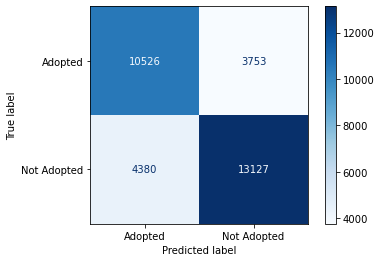

In [22]:
#show confusion matrix

cm = confusion_matrix(y_test, preds)

ConfusionMatrixDisplay(cm, display_labels=rf.classes_).plot(cmap='Blues');

In [23]:
#print out feature importances from model

importance = rf.feature_importances_

sorted(set(zip(importance, X.columns )), reverse=True)

[(0.12868816116743137, 'age_upon_intake'),
 (0.05260804367175956, 'is_named_in'),
 (0.024427676991748432, 'sex_upon_intake_Unknown'),
 (0.02037364040845104, 'intake_type_Owner Surrender'),
 (0.020163465967237632, 'intake_type_Public Assist'),
 (0.017277887990982864, 'sex_upon_intake_Intact Male'),
 (0.01627470442108963, 'day_in_Monday'),
 (0.015970100254173232, 'day_in_Wednesday'),
 (0.01582733647400358, 'day_in_Tuesday'),
 (0.015447806405214988, 'day_in_Thursday'),
 (0.015227873422752837, 'day_in_Saturday'),
 (0.014060799347188253, 'sex_upon_intake_Neutered Male'),
 (0.013690464317378519, 'day_in_Sunday'),
 (0.013466330947407304, 'intake_type_Stray'),
 (0.012378809669440357, 'intake_condition_Normal'),
 (0.011845622234589702, 'color_white black'),
 (0.011493336192848118, 'month_in_5'),
 (0.01142995652369343, 'sex_upon_intake_Spayed Female'),
 (0.011325254354334164, 'month_in_10'),
 (0.01131830574557666, 'month_in_7'),
 (0.011255603064313908, 'prev_adoption'),
 (0.011246152339806088, '

Our random forrest classifier model has a 74% accuracy rate on predicting if a pet will be adopted or not, which is outperforming the baseline by about 20%. We can see from the print out above that the top 5 features with the greatest importance in our model are age upon intake, is named in, sex upon intake Unknown, intake type owner surrender, and intake type public assist.

In [ ]:
#pickle model for production on streamlit

#with open('./rf.pkl', 'wb') as pickle_out:
    #pickle_out = pickle.dump(rf, pickle_out)